## Lesson 6: Semantic Search, Building a Q&A System

#### Project environment setup

- Load credentials and relevant Python Libraries

In [ ]:
from utils import authenticate
credentials, PROJECT_ID = authenticate()

#### Enter project details

In [ ]:
REGION = 'us-central1'

In [ ]:
import vertexai
vertexai.init(project=PROJECT_ID, location=REGION, credentials = credentials)

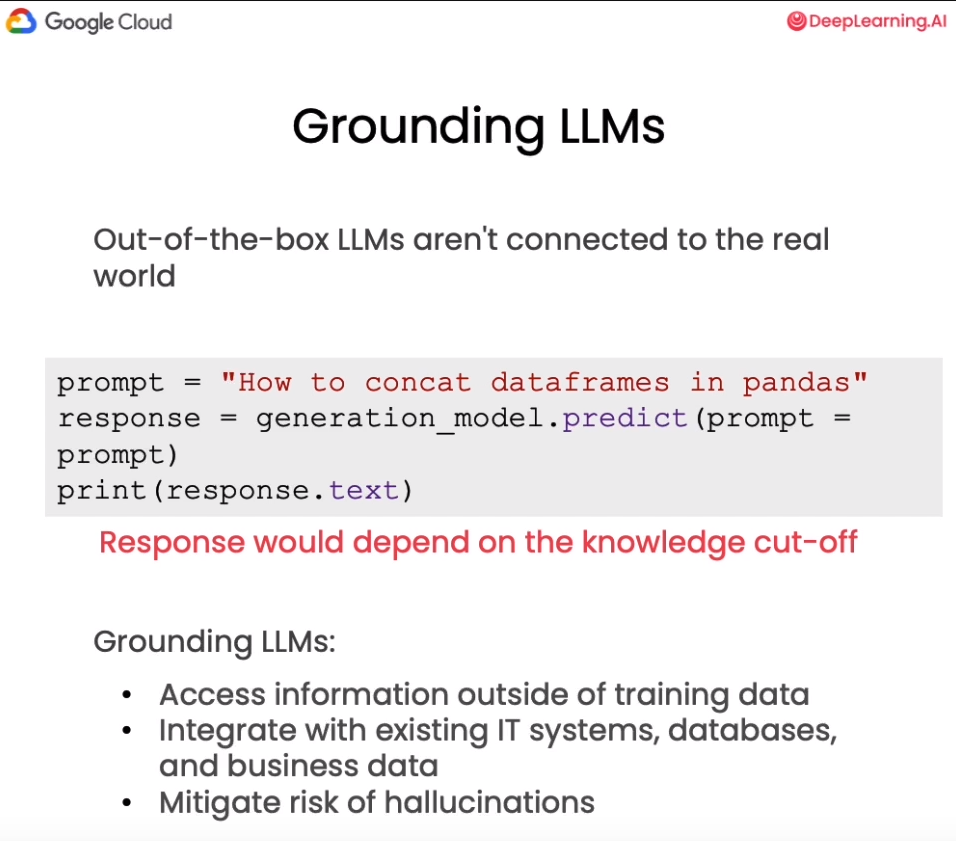

## Load Stack Overflow questions and answers from BigQuery

In [ ]:
import pandas as pd

In [ ]:
so_database = pd.read_csv('so_database_app.csv')

In [ ]:
print("Shape: " + str(so_database.shape))
print(so_database)

## Load the question embeddings

In [ ]:
from vertexai.language_models import TextEmbeddingModel

In [ ]:
embedding_model = TextEmbeddingModel.from_pretrained(
    "textembedding-gecko@001")

In [ ]:
import numpy as np
from utils import encode_text_to_embedding_batched

- Here is the code that embeds the text.  You can adapt it for use in your own projects.  
- To save on API calls, we've embedded the text already, so you can load it from the saved file in the next cell.

```Python
# Encode the stack overflow data

so_questions = so_database.input_text.tolist()
question_embeddings = encode_text_to_embedding_batched(
            sentences = so_questions,
            api_calls_per_second = 20/60, 
            batch_size = 5)
```

In [ ]:
import pickle
with open('question_embeddings_app.pkl', 'rb') as file:
      
    # Call load method to deserialze
    question_embeddings = pickle.load(file)
  
    print(question_embeddings)

In [ ]:
so_database['embeddings'] = question_embeddings.tolist()

In [ ]:
so_database

## Semantic Search

When a user asks a question, we can embed their query on the fly and search over all of the Stack Overflow question embeddings to find the most simliar datapoint.

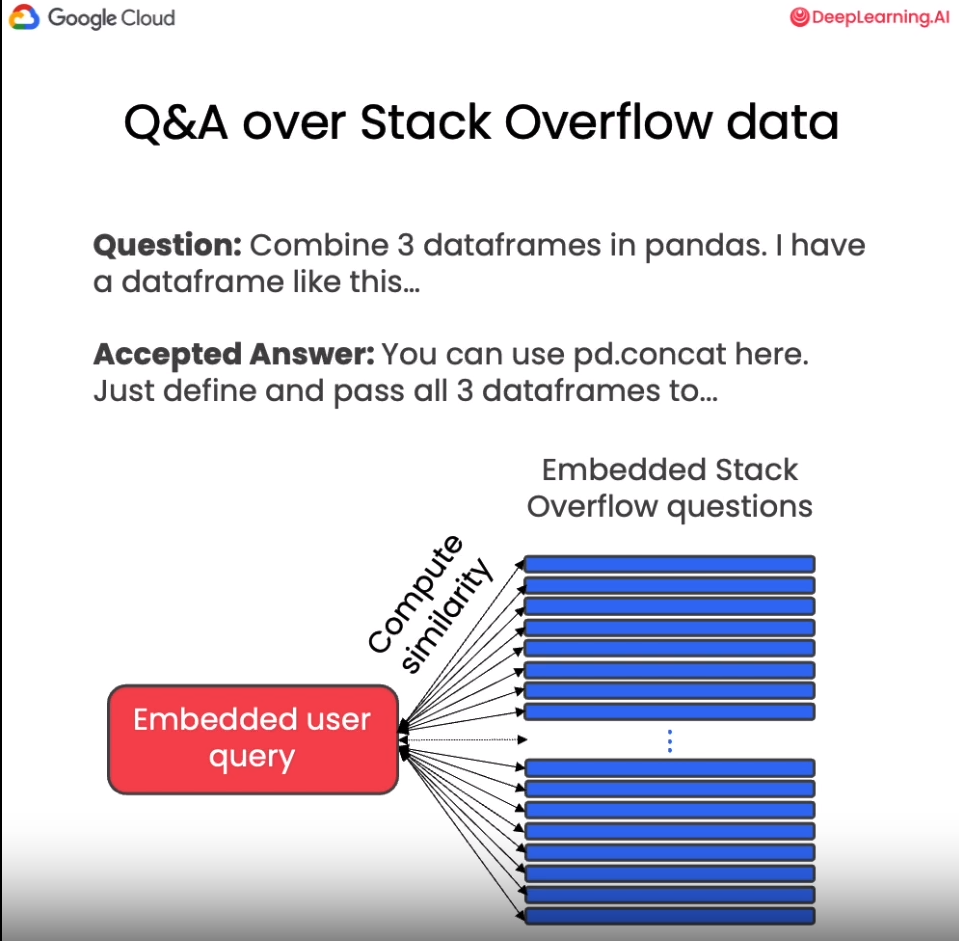

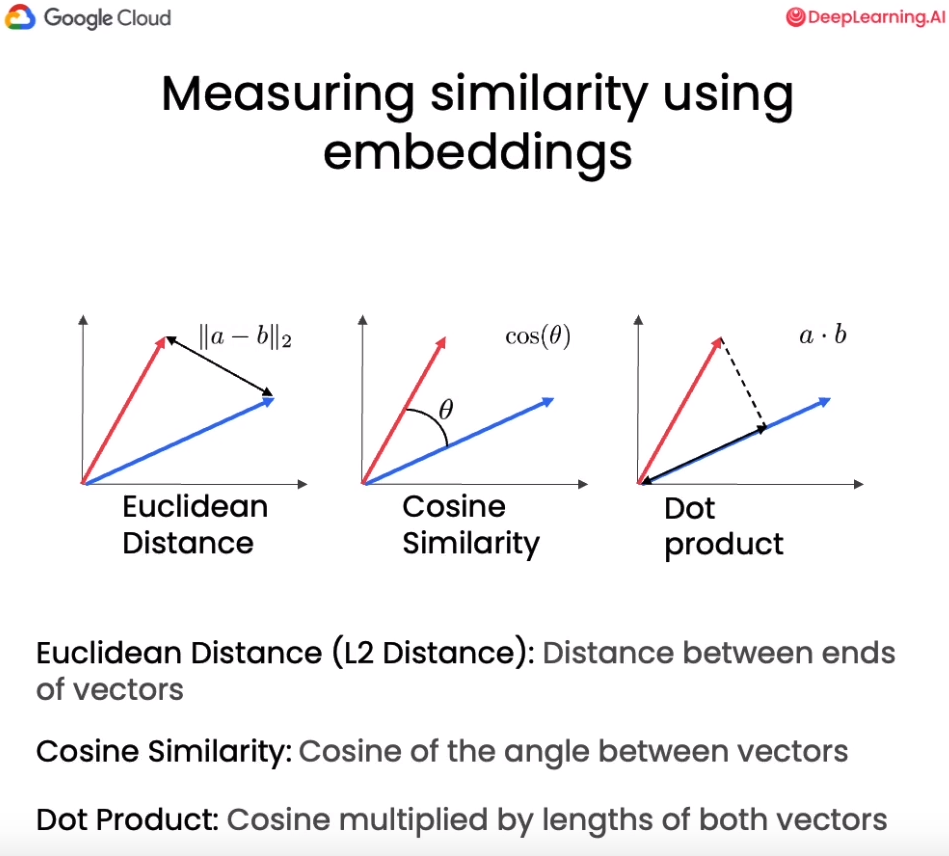


In [ ]:
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances_argmin as distances_argmin

In [ ]:
query = ['How to concat dataframes pandas']

In [ ]:
query_embedding = embedding_model.get_embeddings(query)[0].values

In [ ]:
cos_sim_array = cosine_similarity([query_embedding],
                                  list(so_database.embeddings.values))

In [ ]:
cos_sim_array.shape

Once we have a similarity value between our query embedding and each of the database embeddings, we can extract the index with the highest value. This embedding corresponds to the Stack Overflow post that is most similiar to the question "How to concat dataframes pandas".

In [ ]:
index_doc_cosine = np.argmax(cos_sim_array)

In [ ]:
index_doc_distances = distances_argmin([query_embedding], 
                                       list(so_database.embeddings.values))[0]

In [ ]:
so_database.input_text[index_doc_cosine]

In [ ]:
so_database.output_text[index_doc_cosine]

## Question answering with relevant context

Now that we have found the most simliar Stack Overflow question, we can take the corresponding answer and use an LLM to produce a more conversational response.

In [ ]:
from vertexai.language_models import TextGenerationModel

In [ ]:
generation_model = TextGenerationModel.from_pretrained(
    "text-bison@001")

In [ ]:
context = "Question: " + so_database.input_text[index_doc_cosine] +\
"\n Answer: " + so_database.output_text[index_doc_cosine]

In [ ]:
prompt = f"""Here is the context: {context}
             Using the relevant information from the context,
             provide an answer to the query: {query}."
             If the context doesn't provide \
             any relevant information, \
             answer with \
             [I couldn't find a good match in the \
             document database for your query]
             """

In [ ]:
from IPython.display import Markdown, display

t_value = 0.2
response = generation_model.predict(prompt = prompt,
                                    temperature = t_value,
                                    max_output_tokens = 1024)

display(Markdown(response.text))

## When the documents don't provide useful information

Our current workflow returns the most similar question from our embeddings database. But what do we do when that question isn't actually relevant when answering the user query? In other words, we don't have a good match in our database.

In addition to providing a more conversational response, LLMs can help us handle these cases where the most similiar document isn't actually a reasonable answer to the user's query.

In [ ]:
query = ['How to make the perfect lasagna']

In [ ]:
query_embedding = embedding_model.get_embeddings(query)[0].values

In [ ]:
cos_sim_array = cosine_similarity([query_embedding], 
                                  list(so_database.embeddings.values))

In [ ]:
cos_sim_array

In [ ]:
index_doc = np.argmax(cos_sim_array)

In [ ]:
context = so_database.input_text[index_doc] + \
"\n Answer: " + so_database.output_text[index_doc]

In [ ]:
prompt = f"""Here is the context: {context}
             Using the relevant information from the context,
             provide an answer to the query: {query}."
             If the context doesn't provide \
             any relevant information, answer with 
             [I couldn't find a good match in the \
             document database for your query]
             """

In [ ]:
t_value = 0.2
response = generation_model.predict(prompt = prompt,
                                    temperature = t_value,
                                    max_output_tokens = 1024)
display(Markdown(response.text))

## Scale with approximate nearest neighbor search

When dealing with a large dataset, computing the similarity between the query and each original embedded document in the database might be too expensive. Instead of doing that, you can use approximate nearest neighbor algorithms that find the most similar documents in a more efficient way.

These algorithms usually work by creating an index for your data, and using that index to find the most similar documents for your queries. In this notebook, we will use ScaNN to demonstrate the benefits of efficient vector similarity search. First, you have to create an index for your embedded dataset.

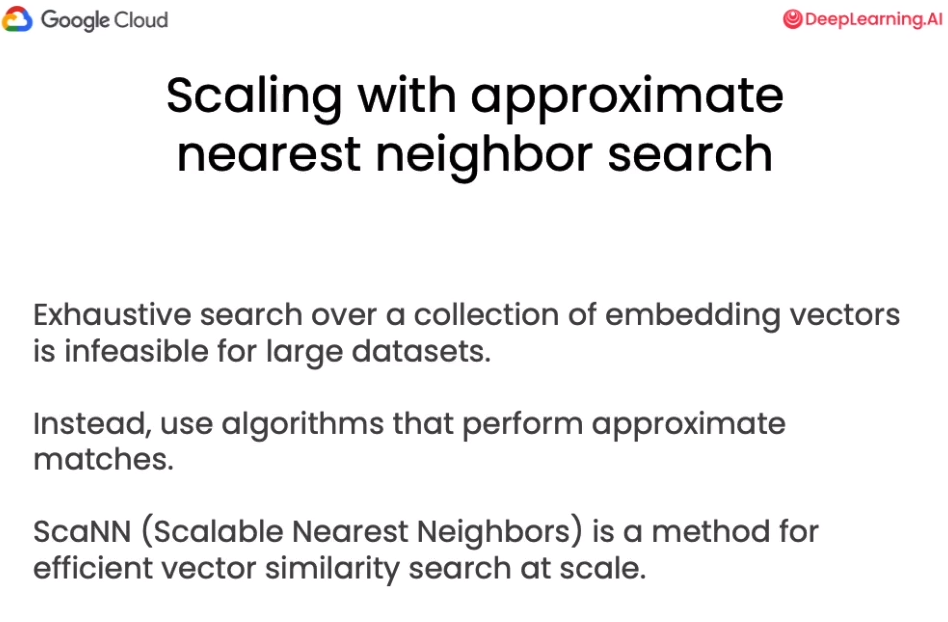


In [ ]:
import scann
from utils import create_index

#Create index using scann
index = create_index(embedded_dataset = question_embeddings, 
                     num_leaves = 25,
                     num_leaves_to_search = 10,
                     training_sample_size = 2000)

In [ ]:
query = "how to concat dataframes pandas"

In [ ]:
import time 

start = time.time()
query_embedding = embedding_model.get_embeddings([query])[0].values
neighbors, distances = index.search(query_embedding, final_num_neighbors = 1)
end = time.time()

for id, dist in zip(neighbors, distances):
    print(f"[docid:{id}] [{dist}] -- {so_database.input_text[int(id)][:125]}...")

print("Latency (ms):", 1000 * (end - start))

In [ ]:
start = time.time()
query_embedding = embedding_model.get_embeddings([query])[0].values
cos_sim_array = cosine_similarity([query_embedding], list(so_database.embeddings.values))
index_doc = np.argmax(cos_sim_array)
end = time.time()

print(f"[docid:{index_doc}] [{np.max(cos_sim_array)}] -- {so_database.input_text[int(index_doc)][:125]}...")

print("Latency (ms):", 1000 * (end - start))

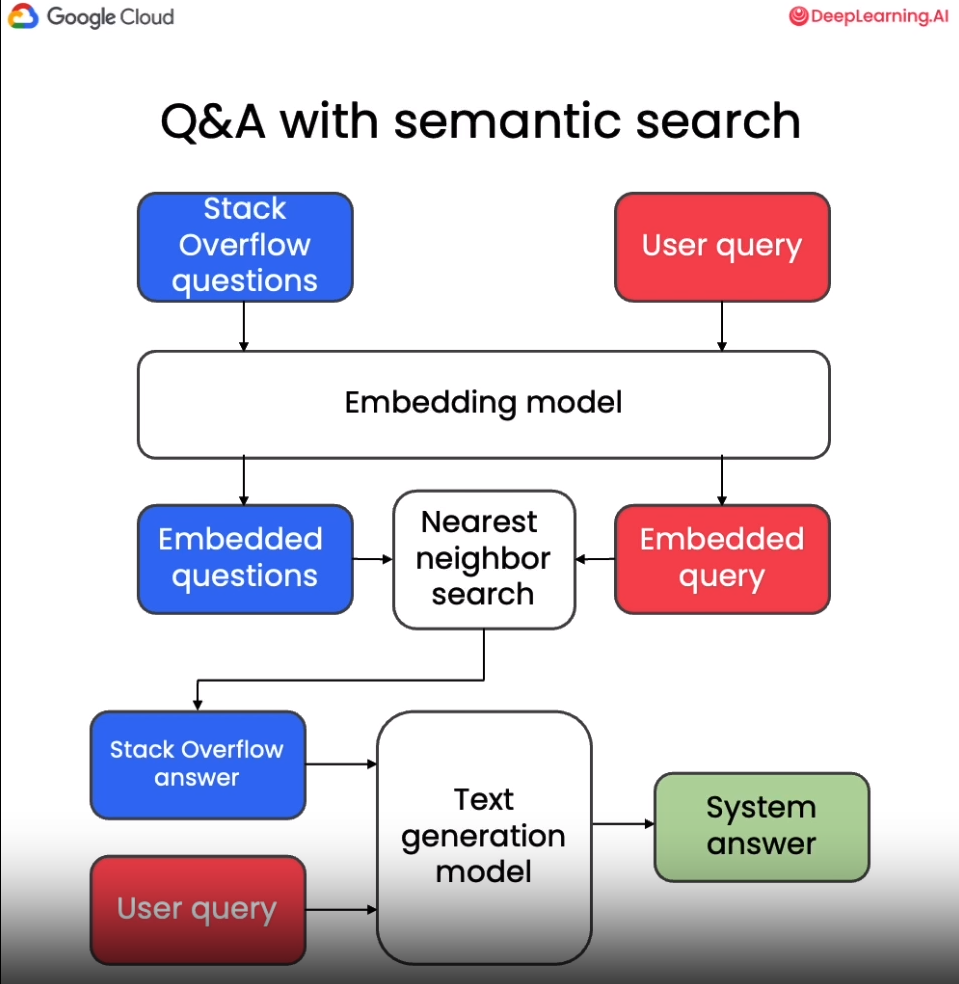